In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import pandas as pd
import pystan
import seaborn as sns
from io import StringIO

sns.set_context('notebook')
sns.set_palette('colorblind')
sns.set_style('ticks')

/Users/rmorgan/anaconda3/envs/mcmc_dsfp/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [3]:
def plot_fitted_line(fit, x, y, xerr=None, yerr=None):
    xmin = np.min(x)
    xmax = np.max(x)
    
    xmin, xmax = (xmin - 0.1*(xmax-xmin)), (xmax + 0.1*(xmax-xmin))
    
    xs = linspace(xmin, xmax, 100)
    ys = []
    for m, b in zip(fit.posterior.m.values.flatten(), fit.posterior.b.values.flatten()):
        ys.append(m*xs + b)
    ys = array(ys)
    
    l, = plot(xs, median(ys, axis=0))
    fill_between(xs, percentile(ys, 84, axis=0), percentile(ys, 16, axis=0), color=l.get_color(), alpha=0.25)
    fill_between(xs, percentile(ys, 97.5, axis=0), percentile(ys, 2.5, axis=0), color=l.get_color(), alpha=0.25)
    
    # Plot the data
    errorbar(x, y, xerr=xerr, yerr=yerr, color='k', fmt='.')
    
def plot_inferred_ys_noscatter(fit, x):
    ys = []
    for m, b in zip(fit.posterior.m.values.flatten(), fit.posterior.b.values.flatten()):
        ys.append(m*x + b)
    ys = array(ys)
    
    errorbar(x, mean(ys, axis=0), yerr=std(ys, axis=0), fmt='.')

Here is the Hogg, Bovy & Lang (2010) data set (normally so good at this, they neglected to publish the data separately, so I had to scrape the PDF):

In [4]:
hogg_data = pd.read_csv(StringIO("""ID	x	y	sigma_x	sigma_y	rho_xy
1	201	592	61	9	-0.84
2	244	401	25	4	0.31
3	47	583	38	11	0.64
4	287	402	15	7	-0.27
5	203	495	21	5	-0.33
6	58	173	15	9	0.67
7	210	479	27	4	-0.02
8	202	504	14	4	-0.05
9	198	510	30	11	-0.84
10	158	416	16	7	-0.69
11	165	393	14	5	0.30
12	201	442	25	5	-0.46
13	157	317	52	5	-0.03
14	131	311	16	6	0.50
15	166	400	34	6	0.73
16	160	337	31	5	-0.52
17	186	423	42	9	0.90
18	125	334	26	8	0.40
19	218	533	16	6	-0.78
20	146	344	22	5	-0.56
"""), sep='\t')
hogg_data

,ID,x,y,sigma_x,sigma_y,rho_xy
0,1,201,592,61,9,-0.84
1,2,244,401,25,4,0.31
2,3,47,583,38,11,0.64
3,4,287,402,15,7,-0.27
4,5,203,495,21,5,-0.33
5,6,58,173,15,9,0.67
6,7,210,479,27,4,-0.02
7,8,202,504,14,4,-0.05
8,9,198,510,30,11,-0.84
9,10,158,416,16,7,-0.69


<ErrorbarContainer object of 3 artists>

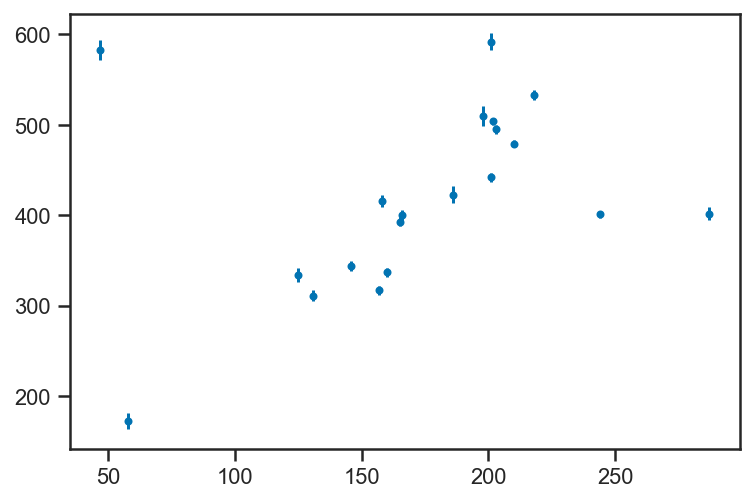

In [5]:
errorbar(hogg_data['x'], hogg_data['y'], yerr=hogg_data['sigma_y'], fmt='.')

In [6]:
igood = 4

<ErrorbarContainer object of 3 artists>

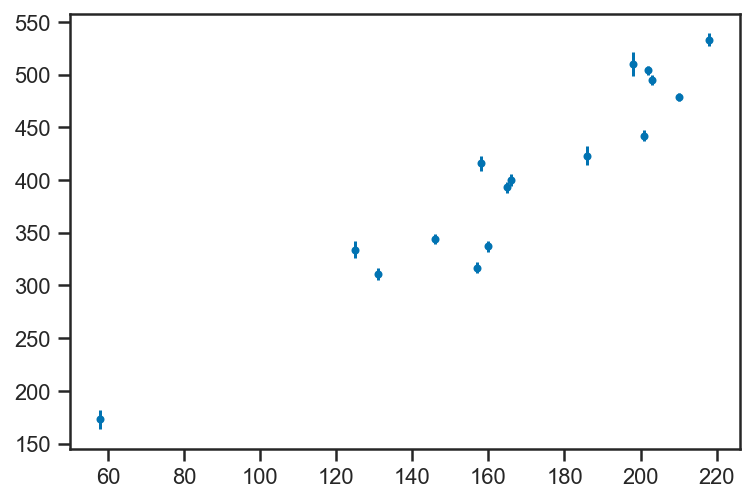

In [7]:
errorbar(hogg_data['x'][igood:], hogg_data['y'][igood:], yerr=hogg_data['sigma_y'][igood:], fmt='.')

In [8]:
model = pystan.StanModel(file='../stan/linear.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3d242dc879ec246da3d07c30fb04b270 NOW.


In [9]:
data = {
    'nobs': len(hogg_data['x'])-igood,
    'xobs': hogg_data['x'][igood:],
    'yobs': hogg_data['y'][igood:],
    'sigma_y': hogg_data['sigma_y'][igood:]
}

In [10]:
fit = model.sampling(data=data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e7ffc50>,
      dtype=object)

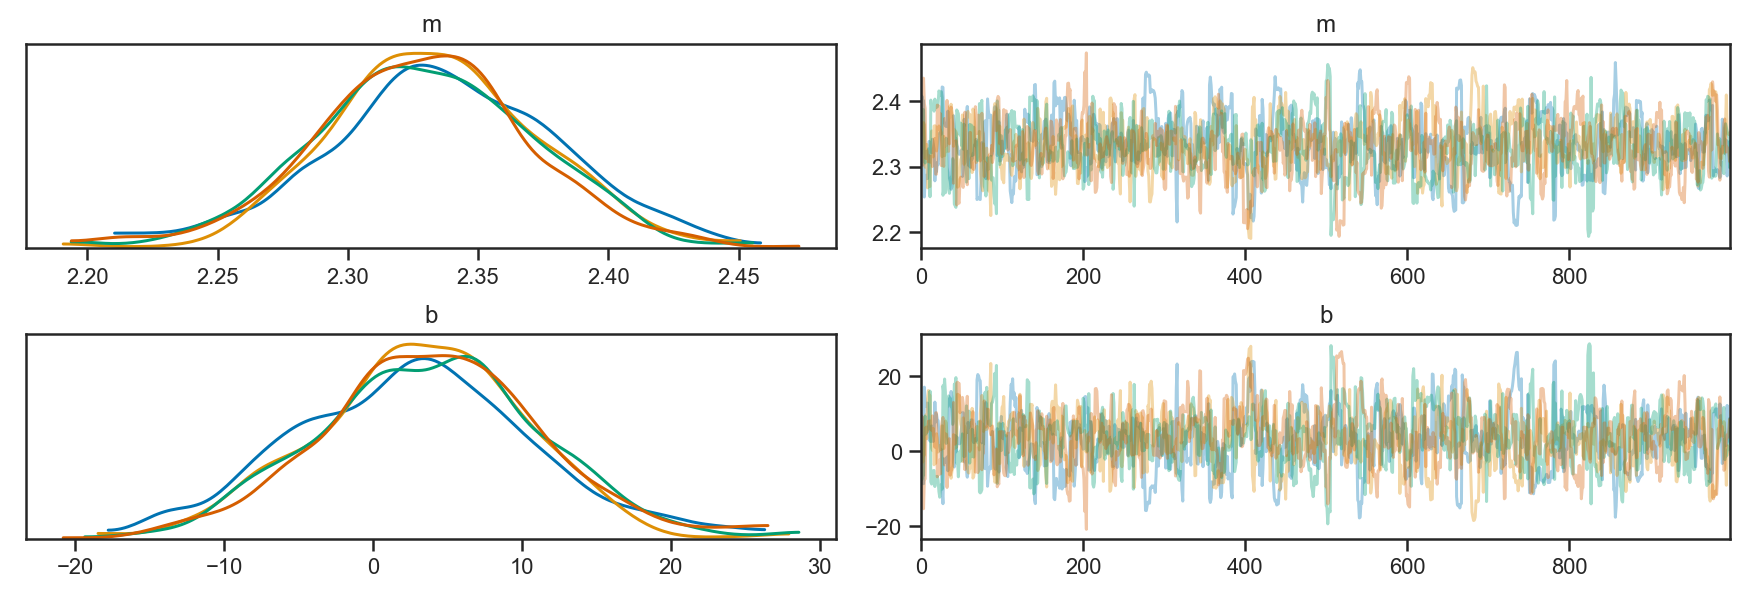

In [11]:
az.plot_trace(fit, var_names=['m', 'b'])

In [12]:
az.effective_sample_size(fit, var_names=['m', 'b'])

<xarray.Dataset>
Dimensions:  ()
Data variables:
    m        float64 712.7
    b        float64 723.2

In [13]:
fit = az.convert_to_inference_data(fit)

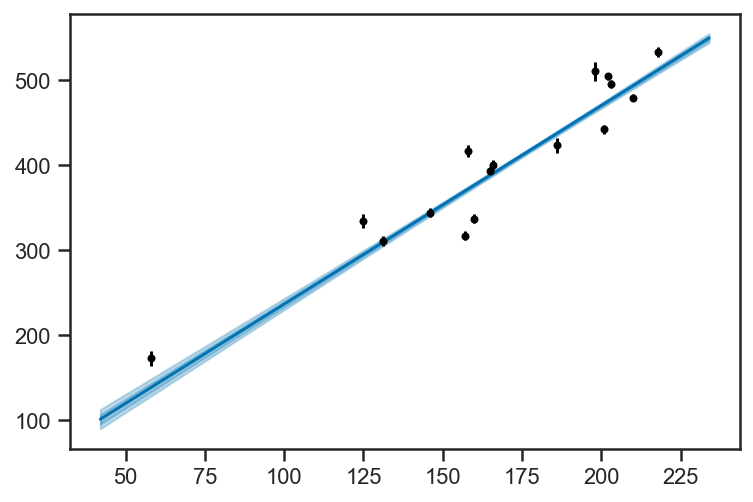

In [14]:
plot_fitted_line(fit, hogg_data['x'][igood:], hogg_data['y'][igood:], yerr=hogg_data['sigma_y'][igood:])

In [15]:
model_scatter = pystan.StanModel(file='../stan/linear_scatter.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_70b05456641533d724ce5ef5460c1644 NOW.


In [16]:
fit_scatter = model_scatter.sampling(data=data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c254b8f90>,
      dtype=object)

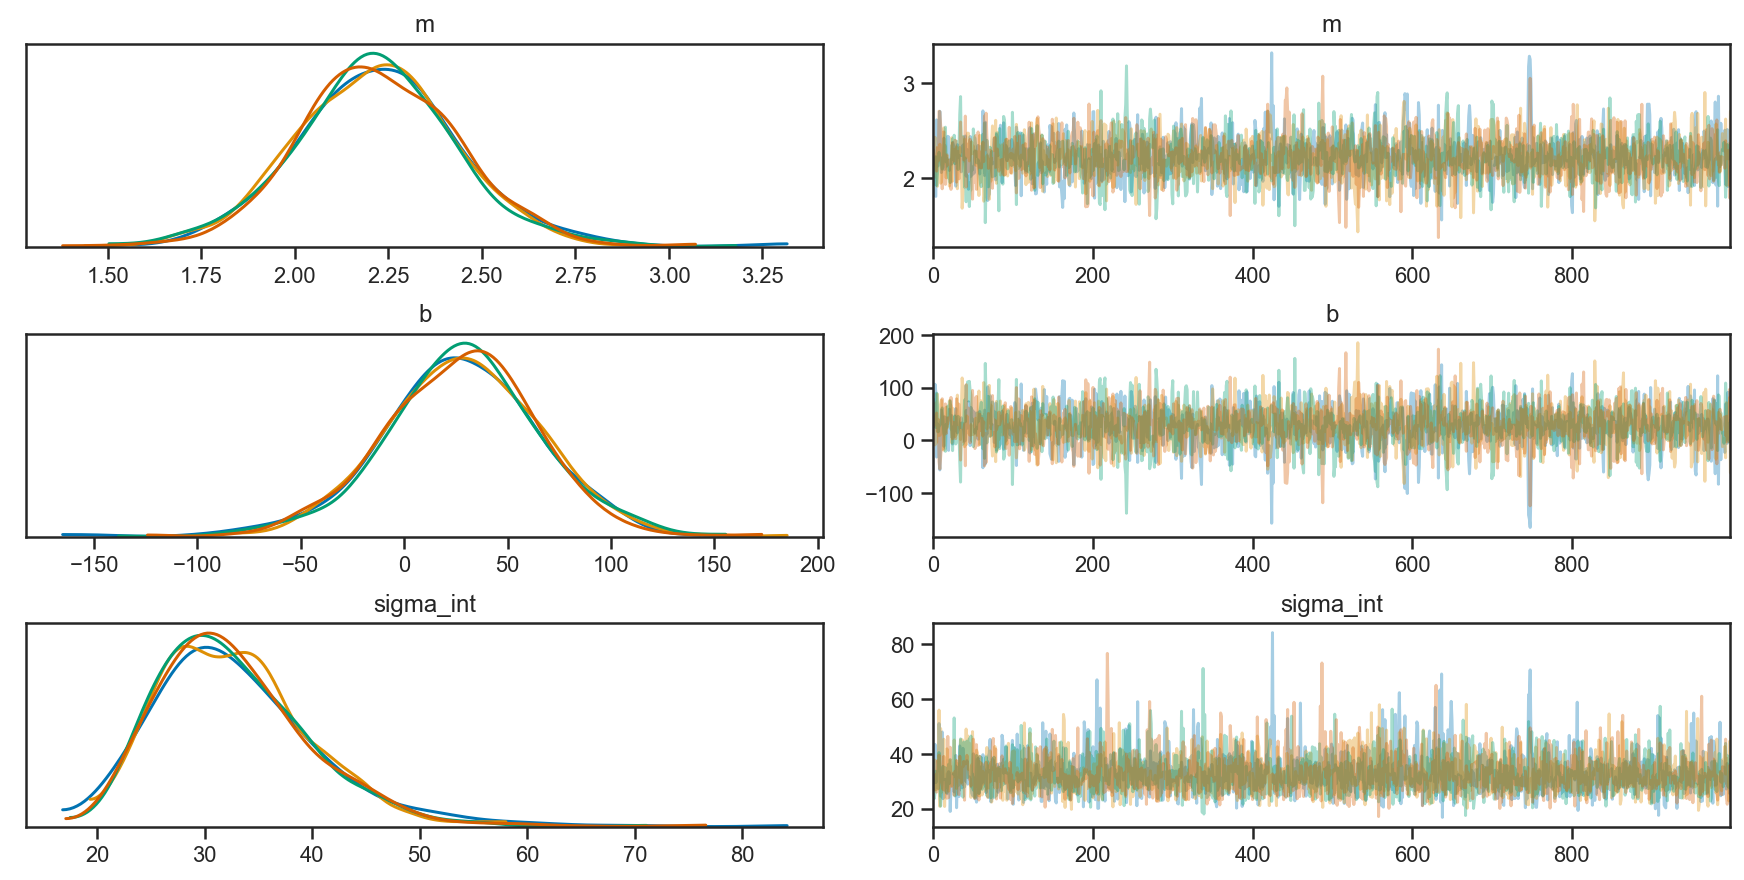

In [17]:
az.plot_trace(fit_scatter, var_names=['m', 'b', 'sigma_int'])

In [18]:
fit_scatter = az.convert_to_inference_data(fit_scatter)

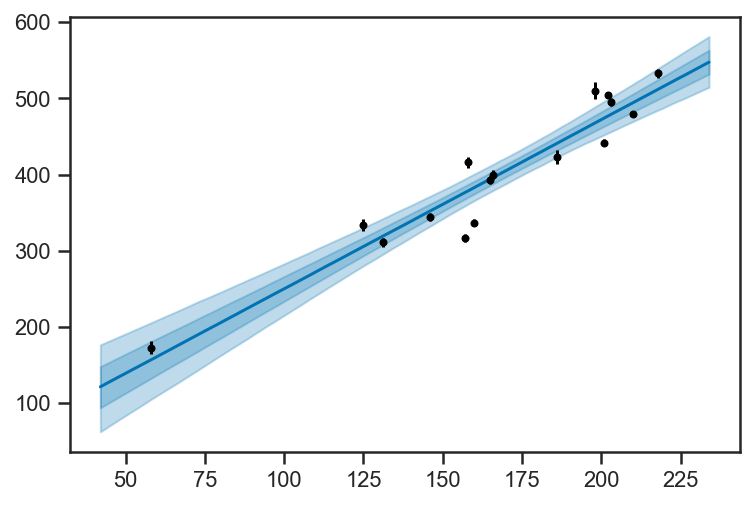

In [19]:
plot_fitted_line(fit_scatter, hogg_data['x'][igood:], hogg_data['y'][igood:], yerr=hogg_data['sigma_y'][igood:])

## Problem 1

Incorporate the uncertainty in the measurement of $x$ from [Hogg, Bovy & Lang (2010)](https://arxiv.org/pdf/1008.4686.pdf) into your model.  You will need to introduce a variable $x_\mathrm{true}$ (just like our $y_\mathrm{true}$) and include an observational likelihood for its values.  Make plots of your fits similar to those we have produced.  Is your model reasonable?  (Remember to fit data points 5 to 20, as the first four points are outliers!)

Can you write a version of this model that uses a mixture model to fit out the outliers, as we did above?

Can you extend your model to account for either intrinsic scatter or inaccuracy in the measurement uncertainties reported in both dimensions, as we did before?  Could you account for both effects in this data set?

In [22]:
data = {
    'nobs': len(hogg_data['x'])-igood,
    'xobs': hogg_data['x'][igood:],
    'yobs': hogg_data['y'][igood:],
    'sigma_y': hogg_data['sigma_y'][igood:],
    'sigma_x': hogg_data['sigma_x'][igood:]
}

In [20]:
model = pystan.StanModel(file='../stan/sigma_x_scatter.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c39bc28eff34676f0aa2ada6f2ead6ea NOW.


In [23]:
fit = model.sampling(data=data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c25a3cc90>,
      dtype=object)

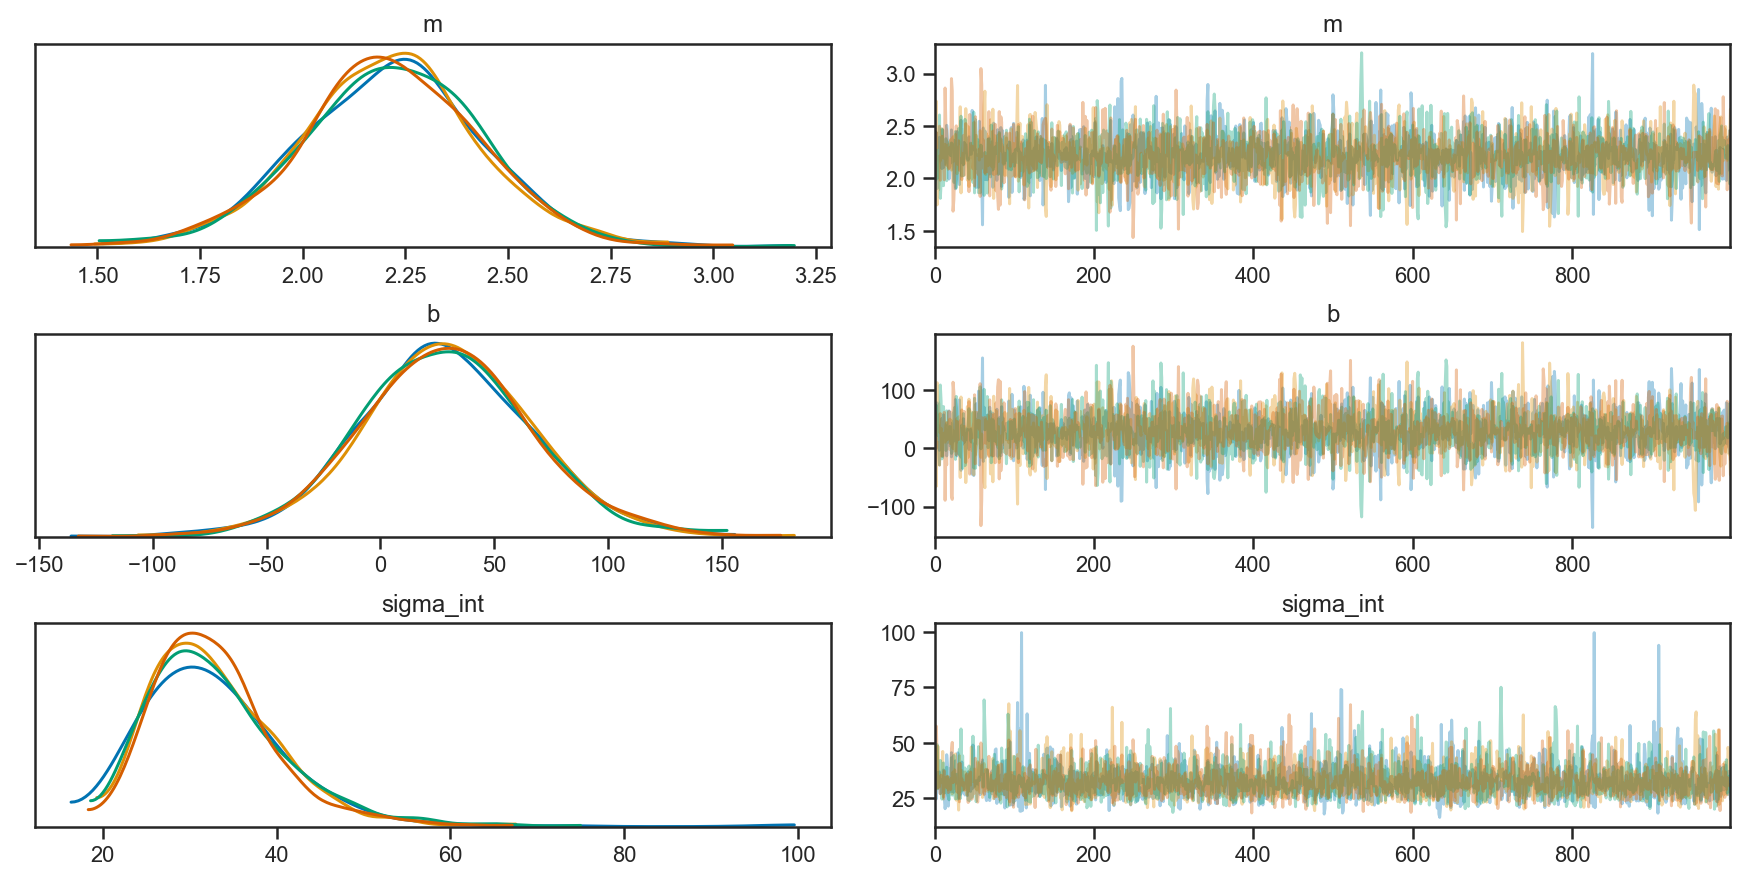

In [24]:
az.plot_trace(fit, var_names=['m', 'b', 'sigma_int'])

In [25]:
fit = az.convert_to_inference_data(fit)

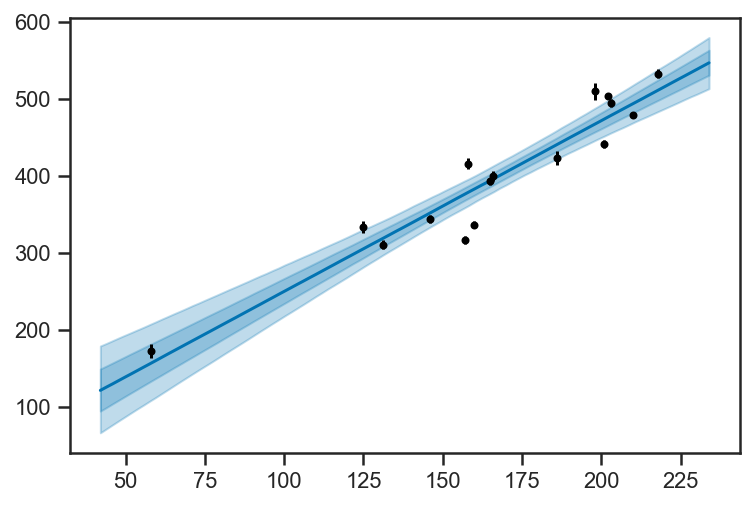

In [26]:
plot_fitted_line(fit, hogg_data['x'][igood:], hogg_data['y'][igood:], yerr=hogg_data['sigma_y'][igood:])

There are the most minimal of differences in the end model after accounting for uncertainty on the x data. Moving on to mixture model?

## Problem 2

Cosmology!  Download the Type Ia supernova dataset from [Scolnic, et al. (2017)](https://arxiv.org/abs/1710.00845); you can find it [here](https://archive.stsci.edu/hlsps/ps1cosmo/scolnic/hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_lcparam-full.txt).  It gives measurements of the redshift (assumed perfectly measured) and distance modulus (imperfectly measured) for some hundreds of supernova from the PanSTARRS survey.  Recall that the distance modulus is 
$$
\mu = 5 \log_{10} \left( \frac{d_L}{10 \, \mathrm{pc}} \right)
$$
and the luminosity distance (see [Hogg (1999)](https://arxiv.org/abs/astro-ph/9905116)) is given in terms of the cosmological parameters of a flat universe by 
$$
d_L\left( z \mid H_0, \Omega_M, w\right) = \frac{c}{H_0} \int_{0}^z \mathrm{d} z \, \frac{1}{\sqrt{\Omega_M \left( 1 + z \right)^3 + \left( 1 - \Omega_M \right) \left( 1 + z \right)^{3(1+w)}}}.
$$

This is a *non-linear* version of the line fitting problem: we have a perfectly-measured redshift; we use cosmology---rather than a linear relation---to predict the luminosity distance, which predicts the distance modulus.  We then compare to the observed distance modulus (plus uncertainty!) to constrain the cosmology.  You can either learn about how to do integrals like the above in Stan (see [here](https://mc-stan.org/docs/2_20/stan-users-guide/integrate-1d.html); but you will need to install a newer version of Stan and do some fancy coding---this is expert-mode!) or you can use the following rational function approximation to $d_L$ that is good to $z \simeq 1.5$ or so:
$$
d_L = \frac{c}{H_0} \frac{z + z^2\frac{3 - 10 w +3 w^2 + 10 w \Omega_M + 6 w^2 \Omega_M - 9 w^2 \Omega_M^2}{4 \left( 1 - 3 w + 3 w \Omega_M \right)}}{1 + z \frac{1 - 2 w -3 w^2 +2 w \Omega_M + 12 w^2 \Omega_M - 9 w^2 \Omega_M^2}{2 \left( 1 - 3 w + 3 w \Omega_M\right)}}
$$

Recall that there are some limits on variables: $0 \leq \Omega_M < 1$, and $0 < H_0$.  So you will need to declare these in the Stan parameters block:

    real<lower=0,upper=1> Om;
    real<lower=0> H0;
   
It is up to you whether you want to encode the weak energy condition $w > -1$ or not.

In [28]:
sn_data = pd.read_csv('../sn_data.csv', delim_whitespace=True)
sn_data.head()

,name,zcmb,zhel,dz,mb,dmb
0,03D1au,0.50309,0.50309,0.0,22.93445,0.12605
1,03D1ax,0.49480,0.49480,0.0,22.88020,0.11765
2,03D1co,0.67767,0.67767,0.0,24.03770,0.20560
3,03D1ew,0.86650,0.86650,0.0,24.34685,0.17385
4,03D1fq,0.79857,0.79857,0.0,24.36050,0.17435


In [29]:
import numpy as np

<ErrorbarContainer object of 3 artists>

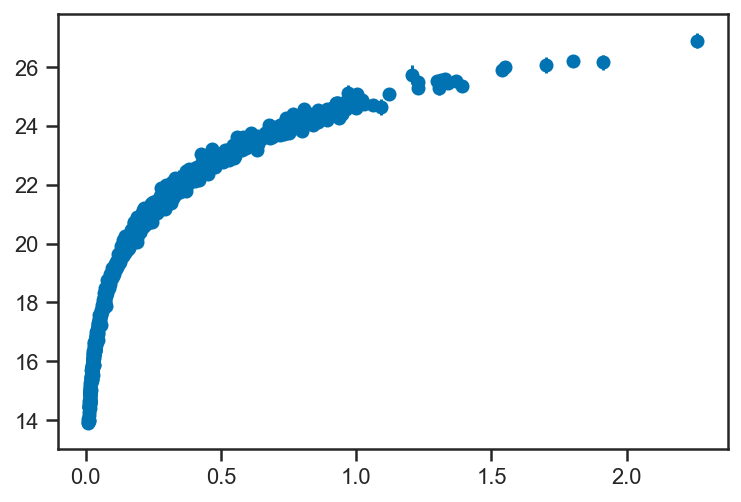

In [31]:
errorbar(sn_data['zhel'], sn_data['mb'], yerr=sn_data['dmb'], fmt='o')

In [53]:
data = {
    'nobs': len(sn_data['zhel']),
    'zobs': sn_data['zhel'],
    'zobs_squared' : [ x * y for x, y in zip(sn_data['zhel'], sn_data['zhel'])],
    'mbobs': sn_data['mb'],
    'dmbobs': sn_data['dmb']
}

In [56]:
model = pystan.StanModel(file='../stan/sn.stan')

ValueError: Failed to parse Stan model 'anon_model_403e69e1881dfbc86cd03fd4a9081413'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:
 error in 'sn.stan' at line 19, column 289
  -------------------------------------------------
    17:   
    18:   for (n in 1:nobs){
    19:   real value = 5 * log_10( (299792 / H0) * (zobs[n] + zobs_squared[n] * ((3 - 10 * w + 3 * w^2 + 10 * w * Om + 6 * w^2 * Om - 9 * w^2 * Om^2) / (4*(1-3 * w + 3 * w * Om))) / (1 + zobs[n] * (1 - 2*w - 3 * w ^ 2 + 2 * w * Om + 12 * w^2 * Om -9 * w^2 * Om^2) / (2 * (1 - 3 * w + 3 * w * Om)));
                                                                                                                                                                                                                                                                                                        ^
    20:   
  -------------------------------------------------

PARSER EXPECTED: ")"


## Problem 3

The paper [Pearson, et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015MNRAS.449.3082P/abstract) tried to calibrate a large number of "mass proxies" for galaxy groups based on simulations.  One of the data sets can be found [here](https://github.com/farr/galmassproxy/blob/master/data/obs_cmproxy.csv).  

You can, of course, take each proxy one-by-one in a linear fit similar to those we have been doing.  But, a better approach is to imagine that the true mass and proxies are drawn from a multivariate normal distribution.  Stan has facilities for modelling the mean vector and covariance matrix of this multivariate normal (see [here](https://mc-stan.org/docs/2_20/functions-reference/distributions-over-unbounded-vectors.html) and [here](https://mc-stan.org/docs/2_20/functions-reference/covariance-matrix-distributions.html) or [here](https://mc-stan.org/docs/2_20/functions-reference/correlation-matrix-distributions.html)).  Write down a model that has (log) true mass and some number of proxies drawn from such a MVN, and then constraints the parameters of this MVN using some number of observations with uncertainty.  Fit it to the data in the datasets directory.

Now extend your model to incorporate some number of observations of only the proxy values (i.e. do not include a term in the likelihood for log mass in this subset of observations); the model can still *predict* masses from the MVN using the proxy observations and the observed common distribution.

Comment on the "meaning" of your model; in particular, what are you assuming about the proxies in the "training" set compared to the "observation" set?  